In [6]:
#Importing packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
#from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from skimage import exposure
from imblearn.over_sampling import SMOTE
from skimage.feature import hog
from tqdm import tqdm

In [2]:
#Loading the pickle file containing a dictionary with 
#patient ID and image ID for keys and the cleaned images for values 
#(from the Data Wrangling notebook).
folder_path = '/kaggle/input/rsna-breast-cancer-detection-data-wrangling/'

with open(folder_path + 'cleaned_images.pickle', 'rb') as file:
    img_dict = pickle.load(file)
    
#Loading the cleaned csv file (also from the Data Wrangling notebook).
df = pd.read_csv(folder_path + 'cleaned_data.csv')

# One-hot encoding

This step has already been done back in the Data Wrangling notebook. To check this, we list the column names of df and also the first few rows of df below. Columns such as 'cancer_0', 'cancer_1', 'implant_0', 'implant_1' etc. were created with get_dummies.

In [3]:
df.columns

Index(['Unnamed: 0', 'site_id', 'patient_id', 'image_id', 'age', 'machine_id',
       'laterality_L', 'laterality_R', 'view_CC', 'view_MLO', 'cancer_0',
       'cancer_1', 'biopsy_0', 'biopsy_1', 'invasive_0', 'invasive_1',
       'BIRADS_0.0', 'BIRADS_1.0', 'BIRADS_2.0', 'implant_0', 'implant_1',
       'density_A', 'density_B', 'density_C', 'density_D',
       'difficult_negative_case_False', 'difficult_negative_case_True'],
      dtype='object')

In [4]:
df.head()

,Unnamed: 0,site_id,patient_id,image_id,age,machine_id,laterality_L,laterality_R,view_CC,view_MLO,...,BIRADS_1.0,BIRADS_2.0,implant_0,implant_1,density_A,density_B,density_C,density_D,difficult_negative_case_False,difficult_negative_case_True
0,0,1,10038,1967300488,60.0,216,1,0,0,1,...,1,0,1,0,0,0,1,0,1,0
1,1,1,10038,2142944869,60.0,216,1,0,1,0,...,1,0,1,0,0,0,1,0,1,0
2,2,1,10038,850559196,60.0,216,0,1,0,1,...,1,0,1,0,0,0,1,0,1,0
3,3,1,10038,1350492010,60.0,216,0,1,1,0,...,1,0,1,0,0,0,1,0,1,0
4,4,1,10042,102733848,51.0,93,1,0,1,0,...,1,0,1,0,0,0,1,0,1,0


# Feature engineering with HOG

Before using a scaler, we need to decide how to use the pixel values as features. Instead of directly using the pixel values, we will use features created by HOG (histogram of oriented gradients). We will also of course use the 'age' columns and the categorical columns (after one-hot encoding) as features. Our feature matrix X then is given by:

In [5]:
X = []

for i in tqdm(range(len(df))):
    key = str(df['patient_id'][i]) + '/' + str(df['image_id'][i])
    resized_img = img_dict[key].resize((275,275))
    arr = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    
    arr = np.append(arr, df['age'][i])
    arr = np.append(arr, df['laterality_L'][i])
    arr = np.append(arr, df['view_CC'][i])
    arr = np.append(arr, df['biopsy_0'][i])
    arr = np.append(arr, df['implant_0'][i])
    arr = np.append(arr, df['invasive_0'][i])
    arr = np.append(arr, df['BIRADS_0.0'][i])
    arr = np.append(arr, df['BIRADS_1.0'][i])
    arr = np.append(arr, df['BIRADS_2.0'][i])
    arr = np.append(arr, df['density_A'][i])
    arr = np.append(arr, df['density_B'][i])
    arr = np.append(arr, df['density_C'][i])
    arr = np.append(arr, df['difficult_negative_case_False'][i])
    
    X.append(arr)


100%|██████████| 23634/23634 [16:50<00:00, 23.39it/s]


Our Y dataframe (consisting of the labels) is:

In [6]:
Y = []

for i in range(len(df)):
    Y.append(df['cancer_1'][i])

In [7]:
#Saving X and Y as pickle files.

fileObj = open('X.pickle', 'wb')
pickle.dump(X,fileObj)
fileObj.close()

fileObj2 = open('Y.pickle', 'wb')
pickle.dump(Y,fileObj2)
fileObj2.close()

# Train-test split

We split the data into a train and a test set, with the test set much larger than the train set.

In [9]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size = 0.1, random_state = 13)

In [10]:
print(len(Xtrain), len(Xtest), len(Ytrain), len(Ytest))

2363 21271 2363 21271


# Oversampling with SMOTE

We now use SMOTE to oversample the minority class. We choose the sampling_strategy to be 0.1.

In [11]:
sm = SMOTE(random_state = 2, k_neighbors = 3, sampling_strategy=0.1)
Xtrain, Ytrain = sm.fit_resample(Xtrain, Ytrain)

In [12]:
print(len(Xtrain),len(Ytrain))
print(Ytrain.count(0))
print(Ytrain.count(1))

2525 2525
2296
229


# Scaling

We scale the train data with MinMaxScaler.

In [13]:
scaler = MinMaxScaler()
scaler.fit(Xtrain)
Xtrain_scaled = scaler.transform(Xtrain)

# PCA

Finally, we use the PCA transformation to reduce the dimensionality of the data.

In [17]:
pca = PCA()
Xtrain_pca = PCA().fit(Xtrain_scaled)

Text(0, 0.5, 'Cumulative ratio variance')

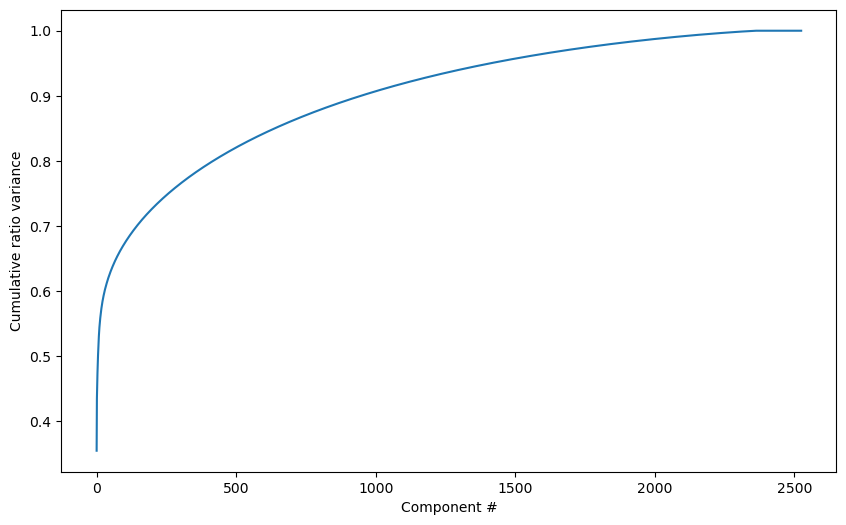

In [18]:
#Plot the cumulative variance ratio with number of components.
plt.subplots(figsize=(10, 6))
plt.plot(Xtrain_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')

We will choose the number of PCA components to be 500, which corresponds to a cumulative ratio variance of around 0.8.

In [21]:
Xtrain_pca_transformed = PCA(n_components=500).fit_transform(Xtrain_scaled)